<a href="https://colab.research.google.com/github/GuQiangJS/finance-tools-py/blob/master/jupyters/%E6%8C%87%E6%A0%87%E7%9B%B8%E5%85%B3%E6%80%A7%E6%B5%8B%E8%AF%95_%E8%B6%8B%E5%8A%BF%E6%80%A7%E6%8C%87%E6%A0%87_%E5%A8%81%E5%BB%89%E6%8C%87%E6%A0%87_WILLR_Williams%E2%80%99_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [初步结论](#scrollTo=kubvmEjMJdFz&line=3&uniqifier=1)：当数值>-20时，观察窗口放大时上涨的概率有总体的61.9%上升到74.1%。

## 安装思源字体

这样显示好看点。呵呵！

In [0]:
import os
if not os.path.exists('/usr/share/fonts/NotoSansCJKsc-Medium.otf'):
    !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKsc-hinted.zip"
    !unzip "NotoSansCJKsc-hinted.zip"
    !mv NotoSansCJKsc-Medium.otf /usr/share/fonts/
from IPython.display import clear_output
clear_output(True)

## 安装第三方库。

[talib](https://www.fmz.com/bbs-topic/1234)，[finance-tools-py](https://github.com/GuQiangJS/finance-tools-py)

In [0]:
try:
    import talib
except ModuleNotFoundError:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    import talib
try:
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.simulation.callbacks.talib import WILLR
    from finance_tools_py.simulation.callbacks import Rolling_Future
except ModuleNotFoundError:
    !pip install git+https://github.com/GuQiangJS/finance-tools-py.git -U
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.simulation.callbacks.talib import WILLR
    from finance_tools_py.simulation.callbacks import Rolling_Future
clear_output(True)

## 其他相关引用

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
# sns.set()
%matplotlib inline
# plt.rcParams['figure.figsize'] = (18, 6)
plt.style.use('ggplot')

fontpath = '/usr/share/fonts/NotoSansCJKsc-Medium.otf'
fontprop = matplotlib.font_manager.FontProperties(fname=fontpath)

plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

import warnings
warnings.filterwarnings('ignore')

# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## 读取数据

1. 读取交易日期、开盘价、最高价、最低价、收盘价、成交量。所有数据均取**前复权**数据。

In [0]:
def read_data():
    symbol='600036'
    data=pd.read_csv('https://raw.githubusercontent.com/GuQiangJS/temp/master/600036_daily.csv',parse_dates=True,
                    usecols=['date','open_qfq','high_qfq','low_qfq','close_qfq','volume_qfq'])
    data['date']=pd.to_datetime(data['date'])
    data.rename(columns={'open_qfq':'open','high_qfq':'high','low_qfq':'low','close_qfq':'close','volume_qfq':'volume'},inplace=True)
    data['preclose']=data['close'].shift()
    data['nextclose']=data['close'].shift(-1)
    data['nextchange']=data['nextclose']-data['close']
    data['nextchange_sign']=np.sign(data['nextchange'])
    return data

In [0]:
def plot(data,**kwargs):
    import plotly
    import plotly.graph_objects as go
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data['date'], y=data['close'],mode='lines',name='close'))
    cols=kwargs.pop('cols',[])
    for col in cols:
        fig.add_trace(go.Scatter(x=data['date'], y=data[col],mode='lines',name=col))
    point=data.loc[data['opt']!=0][1:]
    if not point.empty:
        buymarker=plotly.graph_objects.scatter.Marker(color='red',size=10)
        sellmarker=plotly.graph_objects.scatter.Marker(color='green',size=10)
        fig.add_trace(go.Scatter(x=point.loc[point['opt']==1]['date'], y=point.loc[point['opt']==1]['close'],mode='markers',marker=sellmarker, name='sell point'))
        fig.add_trace(go.Scatter(x=point.loc[point['opt']==2]['date'], y=point.loc[point['opt']==2]['close'],mode='markers',marker=buymarker, name='buy point'))
    fig.update_layout(title="{}日布林带".format(timeperiod,nbdevup,nbdevdn))
    fig.show()

## 指标应用原则

1. WR数值的大小

  和KDJ指标一样，W％R的数值范围为0－100。不同的是W％R指标是以0为顶部，以100为底部。

  1. 当W％R在20－0区间时，是W％R指标的超买区，表明市场处于超买状态，股票价格已进入顶部，可考虑卖出。W％R＝20这一横线，一般视为卖出线。

  2. 当W％R进入80－100区间时，是W％R指标的超卖区，表明市场处于超卖状态，股票价格已近底部，可考虑买入。W％R＝80这一横线，一般视为买入线。

  3. 当W％R在20－80区间时，表明市场上多空暂时取得平衡，股票价格处于横盘整理之中，可考虑持股或持币观望。

  4.在具体实战中，当威廉曲线向上突破20超买线而进入超买区运行时，表明股价进入强势拉升行情，这是提醒投资者要密切关注行情的未来走势，只有当W％R曲线再次向下突破20线时，才为投资者提出预警，为投资者买卖决策提供参考。同样，当威廉曲线向下突破80超卖线而进入超卖区运行时，表明股价的强势下跌已经缓和，这也是提醒投资者可以为建仓作准备，而只有当W％R曲线再次向上突破80线时，投资者才真正短线买入。

2. WR曲线的形状

  1. 当WR曲线从超卖区开始向上爬升，超过80这条买入线时，说明行情可能向上突破，是开始买入的信号。 

  2. 当WR曲线从超买区开始向下回落，跌破20这条卖出线时，说明行情可能向下反转，是开始卖出的信号。 

  3. 当WR曲线由超卖区向上突破50这条多空平衡线时，说明股价涨势较强，可考虑短线加码买入。 

  4. 当WR曲线由超买区向下突破50这条多空平衡线时，说明股价跌势较强，可考虑短线加码卖出。

3. WR指标最佳参数的探讨及买卖决策

  1. 如果取6日为短期W％R指标的参数，则当W％R指标数值小于15时，就可归为W％R指标的短期超买，是短线卖出信号。 

  2. 如果取6日为短期W％R指标的参数，则当W％R指标数值大于85时，就可归为W％R指标的短期超卖，是短线买入信号。 

  3. 如果取20为中期W％R指标的参数，则当W％R指标数值小于20时，就可归为W％R指标的中期超买，是中线卖出信号。 

  4. 如果取20日为中期W％R指标的参数，则当W％R指标数值大于80时，就可归为W％R指标的中期超卖，是中线买入信号。 

  5. 如果取70日为长期W％R指标的参数，则当W％R指标数值小于10时，就可归为W％R指标的长期超买，是长线卖出信号。 

## 数据处理

计算n日的威廉指标数据和未来n日的最大值，最小值，中位数，平均值等数据。

## `14日威廉指标` 与 `未来14日均值/收盘价` 之间的关系。屁都看不出来。

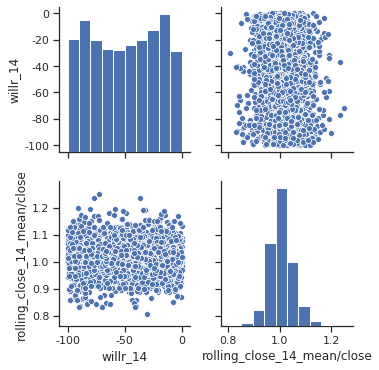

In [10]:
data=read_data()
timeperiod=14
rolling_timeperiod=14
s=Simulation(data,'',callbacks=[WILLR(timeperiod),
                Rolling_Future(timeperiod=rolling_timeperiod)])
s.simulate()
sns.set(style="ticks")
g=sns.pairplot(s.data[[
                   'willr_{}'.format(timeperiod),
                   'rolling_close_{}_mean/close'.format(timeperiod)
                   ]])
# g.fig.set_size_inches(5,5)

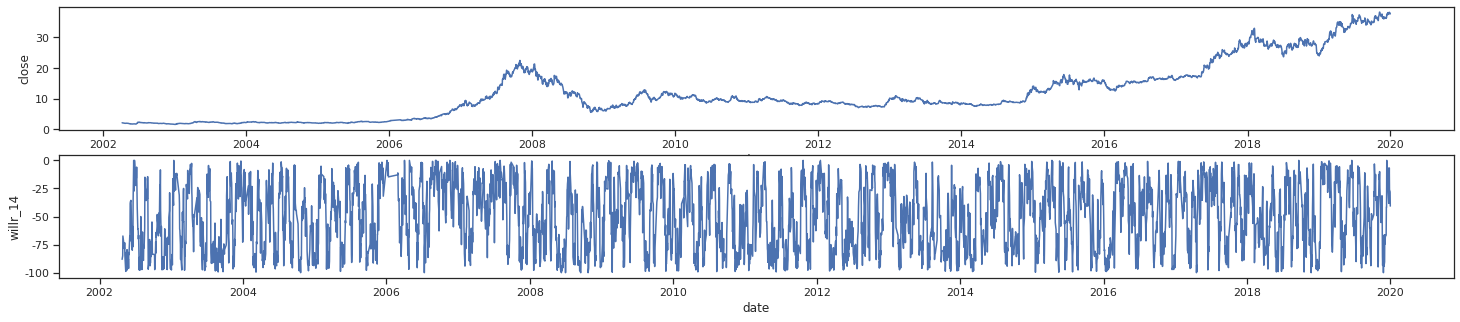

In [11]:
# data[['close','willr_{}'.format(timeperiod)]].plot(subplots=True)
fig,axes=plt.subplots(2,1,figsize=(25,5))
sns.lineplot(data=s.data,x='date',y='close',ax=axes[0])
sns.lineplot(data=s.data,x='date',y='willr_{}'.format(timeperiod),ax=axes[1])

## 拉长指标日期。有点意思了。

指标日期拉长以后看出当指标小于-25的时候是可以入手的低于-75时一定要丢掉

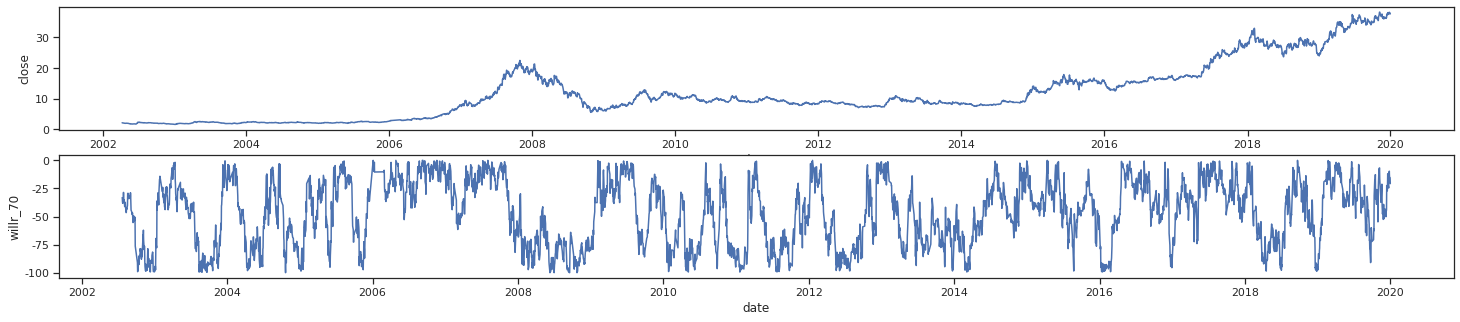

In [12]:
data=read_data()
timeperiod=70
s=Simulation(data,'',callbacks=[WILLR(timeperiod)])
s.simulate()
fig,axes=plt.subplots(2,1,figsize=(25,5))
sns.lineplot(data=s.data,x='date',y='close',ax=axes[0])
sns.lineplot(data=s.data,x='date',y='willr_{}'.format(timeperiod),ax=axes[1])

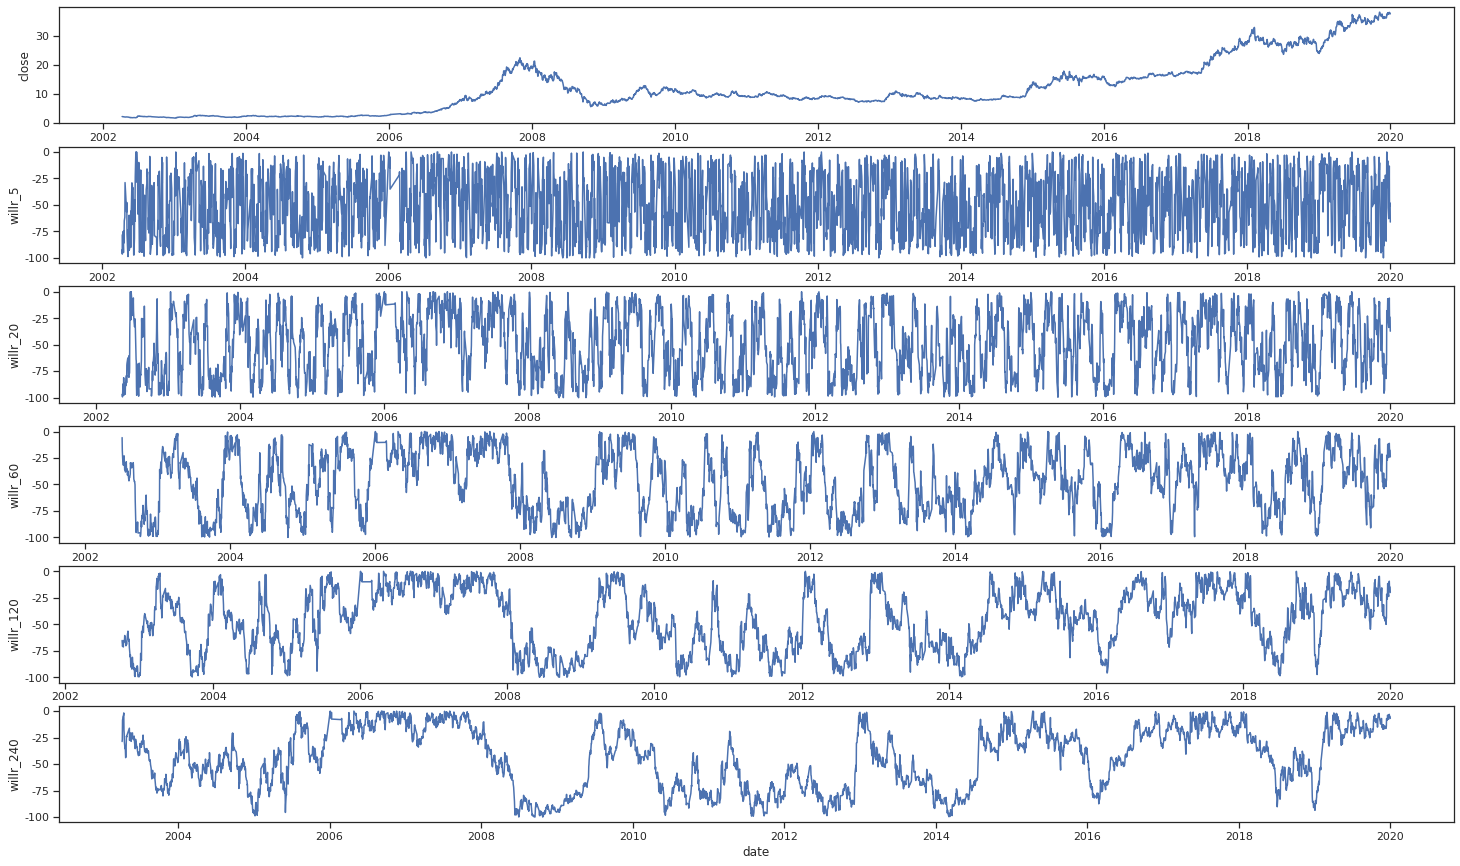

In [40]:
data=read_data()
ds=[5,20,60,120,240]
s=Simulation(data,'',callbacks=[WILLR(i) for i in ds]+[Rolling_Future(timeperiod=i) for i in ds])
s.simulate()
fig,axes=plt.subplots(len(ds)+1,1,figsize=(25,len(ds)*3))
for i,v in enumerate(ds):
    sns.lineplot(data=s.data,x='date',y='willr_{}'.format(v),ax=axes[i+1])
sns.lineplot(data=data,x='date',y='close',ax=axes[0])

## 结论：当日期区间放大还是有点效果的。

当数值>-20时，120日内上涨的概率有总体的61.9%上升到74.1%。

In [41]:
def print_result(s,ds):
    print('原始数据 VS WILLR>-20 在未来 n 天的走势对比(n就是天数值)')
    dfs=[]
    for v in ds:
        s.data['u_{}'.format(v)]=np.sign(s.data['rolling_close_{}_mean'.format(v)]-s.data['close'])
        o=np.round(s.data['u_{}'.format(v)].value_counts(normalize=True).values*100,2)
        n=np.round(s.data[s.data['willr_{}'.format(v)]>-20]['u_{}'.format(v)].value_counts(normalize=True).values*100,2)
        dfs.append(pd.DataFrame({
            '天数':[v],
            '原始(%)':[o[0]],
            'WILLR>-20(%)':[n[0]],
            '差额':[n[0]-o[0]]
        }))

    return pd.concat(dfs)
print_result(s,ds).sort_values('WILLR>-20(%)',ascending=False)

原始数据 VS WILLR>-20 在未来 n 天的走势对比(n就是天数值)


,天数,原始(%),WILLR>-20(%),差额
0,120,61.97,74.17,12.20
0,240,60.71,71.41,10.70
0,60,57.06,57.34,0.28
0,20,54.35,55.51,1.16
0,5,51.03,52.73,1.70


In [0]:
data=read_data()
ds=range(5,240)
s=Simulation(data,'',callbacks=[WILLR(i) for i in ds]+[Rolling_Future(timeperiod=i) for i in ds])
s.simulate()

In [43]:
print_result(s,ds).sort_values('WILLR>-20(%)',ascending=False).head(100)

原始数据 VS WILLR>-20 在未来 n 天的走势对比(n就是天数值)


,天数,原始(%),WILLR>-20(%),差额
0,169,61.96,75.85,13.89
0,168,61.98,75.77,13.79
0,167,62.00,75.77,13.77
0,170,61.95,75.72,13.77
0,166,62.00,75.53,13.53
...,...,...,...,...
0,228,60.78,71.86,11.08
0,231,60.77,71.81,11.04
0,232,60.83,71.81,10.98
0,112,61.40,71.81,10.41
